<a href="https://colab.research.google.com/github/Majoka2001/Car_Class_Prediction/blob/main/Car_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.contingency import association
from scipy.stats import spearmanr, kendalltau
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

In [4]:
car_evaluation.metadata

{'uci_id': 19,
 'name': 'Car Evaluation',
 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation',
 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv',
 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.',
 'area': 'Other',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 1728,
 'num_features': 6,
 'feature_types': ['Categorical'],
 'demographics': [],
 'target_col': ['class'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1988,
 'last_updated': 'Thu Aug 10 2023',
 'dataset_doi': '10.24432/C5JP48',
 'creators': ['Marko Bohanec'],
 'intro_paper': {'ID': 249,
  'type': 'NATIVE',
  'title': 'Knowledge acquisition and explanation for multi-attribute decision making',
  'authors': 'M. Bohanec, V. Rajkovič',
  'venue': '8th Intl Workshop on Expert Syst

In [5]:
car_evaluation.variables

,name,role,type,demographic,description,units,missing_values
0,buying,Feature,Categorical,None,buying price,None,no
1,maint,Feature,Categorical,None,price of the maintenance,None,no
2,doors,Feature,Categorical,None,number of doors,None,no
3,persons,Feature,Categorical,None,capacity in terms of persons to carry,None,no
4,lug_boot,Feature,Categorical,None,the size of luggage boot,None,no
5,safety,Feature,Categorical,None,estimated safety of the car,None,no
6,class,Target,Categorical,None,"evaulation level (unacceptable, acceptable, go...",None,no


In [6]:
X

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


In [7]:
X.isnull().sum()                                       # Check for missing values

,0
buying,0
maint,0
doors,0
persons,0
lug_boot,0
safety,0


**Checking Class Imbalance for the features in dataset**

<Axes: ylabel='Class Imbalance in Car Evaluation'>

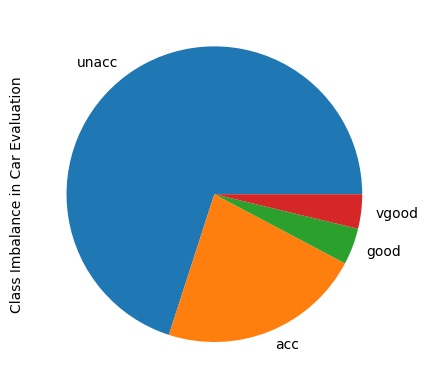

In [8]:
y['class'].value_counts().plot(kind='pie', label='Class Imbalance in Car Evaluation')

In [9]:
y['class'].value_counts()

,count
class,
unacc,1210
acc,384
good,69
vgood,65


In [10]:
X['maint'].value_counts()

,count
maint,
vhigh,432
high,432
med,432
low,432


In [11]:
X['buying'].value_counts()

,count
buying,
vhigh,432
high,432
med,432
low,432


In [12]:
X['lug_boot'].value_counts()

,count
lug_boot,
small,576
med,576
big,576


In [13]:
X['safety'].value_counts()

,count
safety,
low,576
med,576
high,576


In [14]:
X['doors']=X['doors'].replace({'5more':'5+'})

<ipython-input-14-ae7123b749fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['doors']=X['doors'].replace({'5more':'5+'})


In [15]:
X['persons']=X['persons'].replace({'more':'4+'})

<ipython-input-15-31029f5c9321>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['persons']=X['persons'].replace({'more':'4+'})


In [16]:
X

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5+,4+,med,med
1724,low,low,5+,4+,med,high
1725,low,low,5+,4+,big,low
1726,low,low,5+,4+,big,med


**Let's look at the most desirable combination of features in a Car**

In [17]:
vgood_class_index=[idx for idx in y[y['class']=='vgood'].index]

In [18]:
vgood_class_X=X.drop(index=[idx for idx in X.index if idx not in vgood_class_index])

In [19]:
vgood_class_X

,buying,maint,doors,persons,lug_boot,safety
1097,med,med,2,4,big,high
1106,med,med,2,4+,big,high
1124,med,med,3,4,big,high
1130,med,med,3,4+,med,high
1133,med,med,3,4+,big,high
...,...,...,...,...,...,...
1700,low,low,4,4+,big,high
1715,low,low,5+,4,med,high
1718,low,low,5+,4,big,high
1724,low,low,5+,4+,med,high


In [20]:
vgood_class_X['buying'].value_counts()               # Price must be either low or medium for a car to be classified as 'very good'

,count
buying,
low,39
med,26


In [21]:
vgood_class_X['maint'].value_counts()                 # High Maintenance Cost is typically not a desirable feature as shown by value_counts() function

,count
maint,
med,26
low,26
high,13


In [22]:
vgood_class_X['doors'].value_counts()                   # Higher number of doors guarantees higher rating for the car as it provides more ease of access

,count
doors,
5+,20
4,20
3,15
2,10


In [23]:
vgood_class_X['persons'].value_counts()                   # Higher Seating Capacity confirms higher rating for the car

,count
persons,
4+,35
4,30


**Conclusion: Examination of the features in the dataset reveals the most important combination of features for a car to be rated as 'very good'. The price and maintenance cost must be low or medium with high number of doors and high seating capacity with a high safety rating.**

**Checking Correlations between features:**

In [24]:
X_y_merged=pd.concat([X, y], axis=1)

In [25]:
X_y_merged

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5+,4+,med,med,good
1724,low,low,5+,4+,med,high,vgood
1725,low,low,5+,4+,big,low,unacc
1726,low,low,5+,4+,big,med,good


In [26]:
contingency_table = pd.crosstab(X_y_merged['maint'], X_y_merged['safety'])

In [27]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

In [28]:
cramers_v = association(contingency_table, method='cramer')

In [29]:
print(f'chi_square statistic: {chi2}')
print(f'p_value: {p}')
print(f'Degrees of Freedom : {dof}')
print(f"Cramer's v: {cramers_v}")

chi_square statistic: 0.0
p_value: 1.0
Degrees of Freedom : 6
Cramer's v: 0.0


**There is no statistical relationship between maintenance cost and safety in your data. Knowing the maintenance level of a car gives you zero predictive power about its safety level — they behave independently. This is indicated by the Cramer's V value being 0.0 and the chi square statistic being 0.0.**

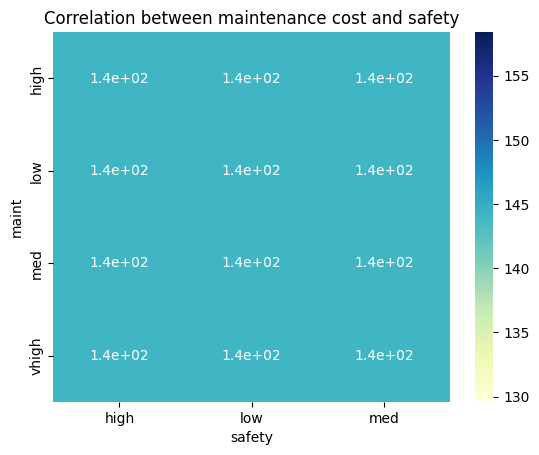

In [30]:
sns.heatmap(pd.crosstab(X_y_merged['maint'], X_y_merged['safety']), annot=True, cmap='YlGnBu')
plt.title('Correlation between maintenance cost and safety')
plt.show()

**The contingency table revealed that each combination of maintenance and safety levels occurred with equal frequency suggesting a perfectly balanced synthetic dataset.
As a result, the test detected no meaningful correlation — which may be counterintuitive, but is a reflection of the data structure, not necessarily real-world logic.
Let's repeat the test for other combinations of features in our dataset:**

In [31]:
contingency_table = pd.crosstab(X_y_merged['buying'], X_y_merged['maint'])
contingency_table

maint,high,low,med,vhigh
buying,,,,
high,108,108,108,108
low,108,108,108,108
med,108,108,108,108
vhigh,108,108,108,108


In [32]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

In [33]:
cramers_v=association(contingency_table, method='cramer')

In [34]:
print(f'chi_square statistic: {chi2}')
print(f'p_value: {p}')
print(f'Degrees of Freedom : {dof}')
print(f"Cramer's v: {cramers_v}")

chi_square statistic: 0.0
p_value: 1.0
Degrees of Freedom : 9
Cramer's v: 0.0


**The contingency table for 'buying' vs 'maintenance' shows no correlation between buying and maintenance cost and this is also proven by the chi square value and cramer's V value being 0.0.**

In [35]:
contingency_table=pd.crosstab(X_y_merged['doors'], X_y_merged['persons'])

In [36]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

In [37]:
cramers_v=association(contingency_table, method='cramer')

In [38]:
print(f'chi square statistic:{chi2}')
print(f'p-value:{p}')
print(f'Degrees of freedom:{dof}')
print(f"Cramer's V:{cramers_v}")

chi square statistic:0.0
p-value:1.0
Degrees of freedom:6
Cramer's V:0.0


**There is no correlation between Number of doors and Seating Capacity in our dataset. It seems counterintuitive but then again, our dataset is a synthetic one for educational purposes instead of reflecting real world relationships.**

In [39]:
contingency_table=pd.crosstab(X_y_merged['persons'], X_y_merged['lug_boot'])

In [40]:
contingency_table

lug_boot,big,med,small
persons,,,
2,192,192,192
4,192,192,192
4+,192,192,192


In [41]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

In [42]:
cramers_v = association(contingency_table, method='cramer')

In [43]:
print(f'chi square statistic : {chi2}')
print(f'p_value : {p}')
print(f'Degrees of freedom : {dof}')
print(f"Cramer's V : {cramers_v}")

chi square statistic : 0.0
p_value : 1.0
Degrees of freedom : 4
Cramer's V : 0.0


**Conclusion: Seating capacity has no correlation with size of luggage boot.
We will now proceed to finding out how the independent features in our data correlate to our target variable and then retain only those variables which have a significant correlation with our target variable and drop those which have little impact on the target.**

In [44]:
contingency_table = pd.crosstab(X_y_merged['buying'], X_y_merged['class'])

In [45]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

In [46]:
cramers_v = association(contingency_table, method='cramer')

In [47]:
print(f'chi square statistic:{chi2}')
print(f'p-value:{p}')
print(f'Degrees of freedom:{dof}')
print(f"Cramer's V:{cramers_v}")

chi square statistic:189.24300964187327
p-value:5.9280625992133936e-36
Degrees of freedom:9
Cramer's V:0.1910633669578305


**The above value for chi square statistic is quite large (189.243) which indicates a strong deviation from the null hypothesis meaning there is a very high probability that the two variables are correlated and the extremely small p-value confirms that. However, the cramer's V value of 0.19106 goes to show that the association between 'buying' cost and 'class' of car have a very slight to moderate association meaning 'buying' alone can not be relied upon to predict class of a car.
There is one limitation with using chi square test to find correltaion between variables; it doesn't accurately capture the ordinal nature of categorical variables and treats the categories as nominal. For that, we must use methods like Kendall's Tau and Spearman's rank correlation.
Let's observe the distribution of the data first:**

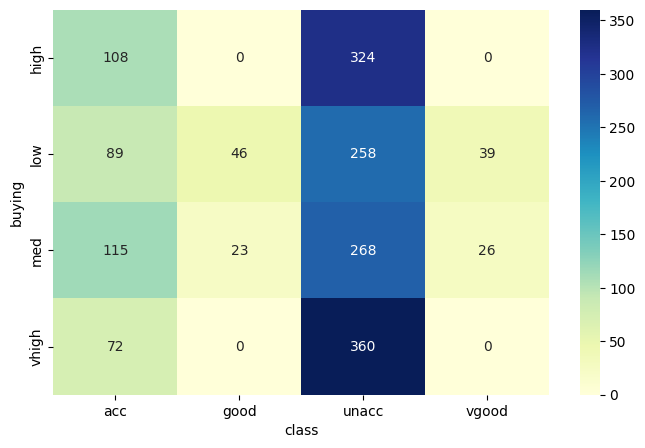

In [48]:
plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

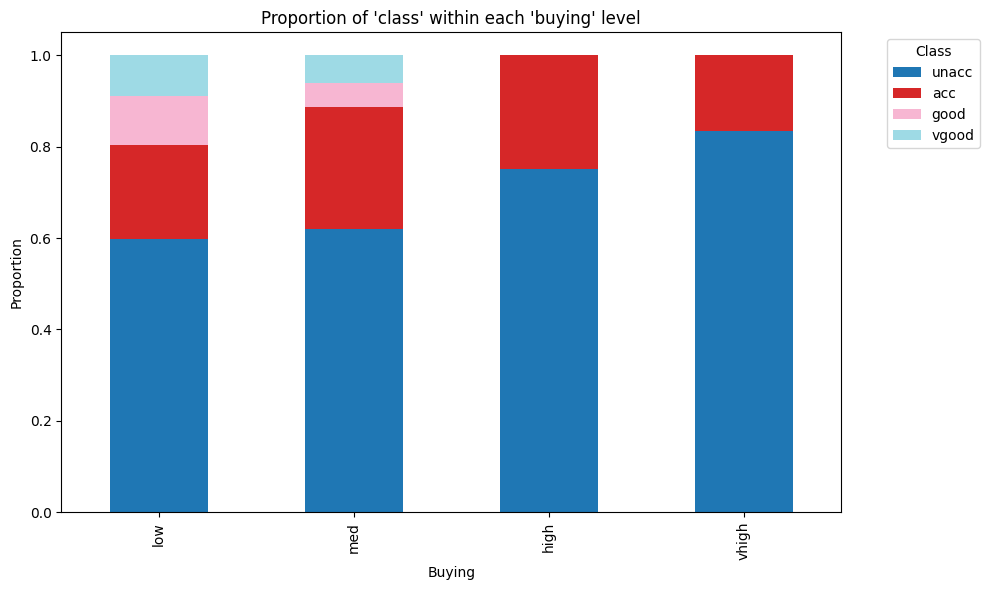

In [49]:
buying_order=['low', 'med', 'high', 'vhigh']
class_order=['unacc', 'acc', 'good', 'vgood']

X_y_merged['buying'] = pd.Categorical(X_y_merged['buying'], categories=buying_order, ordered=True)
X_y_merged['class'] = pd.Categorical(X_y_merged['class'], categories=class_order, ordered=True)

contingency_prop = pd.crosstab(X_y_merged['buying'], X_y_merged['class'], normalize='index')

contingency_prop.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title("Proportion of 'class' within each 'buying' level")
plt.xlabel("Buying")
plt.ylabel("Proportion")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [50]:
buying_map={'low':1, 'med':2, 'high':3, 'vhigh':4}
class_map={'unacc':1, 'acc':2, 'good':3, 'vgood':4}

X_y_merged['buying_ordered']=X_y_merged['buying'].map(buying_map)
X_y_merged['class_ordered']=X_y_merged['class'].map(class_map)

spearman_corr, spearman_p = spearmanr(X_y_merged['buying_ordered'], X_y_merged['class_ordered'])

kendall_corr, kendall_p = kendalltau(X_y_merged['buying_ordered'], X_y_merged['class_ordered'])

print("Spearman’s rho:", spearman_corr, "p-value:", spearman_p)
print("Kendall’s tau-b:", kendall_corr, "p-value:", kendall_p)

Spearman’s rho: -0.23694904349295876 p-value: 1.769668585256624e-23
Kendall’s tau-b: -0.2122958114948199 p-value: 2.2373723757424034e-23


**Conclusion: The extremely small p_values suggest that the correlation between the feature 'buying' and target variable 'class' is not coincidental or random. The small negative values for spearman's rho and Kendall's tau-b imply a weak negative monotonic relationship. This means that as the buying cost increases, the car is more likely to be rated as having a lower quality.**   

**Let's check the relationship between maintenance cost and class of cars in our dataset:**

In [51]:
maintenance_ordered={'low':1, 'med':2, 'high':3, 'vhigh':4}

X_y_merged['maint_ordered']=X_y_merged['maint'].map(maintenance_ordered)

spearman_corr, spearman_p = spearmanr(X_y_merged['maint_ordered'], X_y_merged['class_ordered'])

kendall_corr, kendall_p = kendalltau(X_y_merged['maint_ordered'], X_y_merged['class_ordered'])

print(f"Spearman's rho : {spearman_corr}          p_value: {spearman_p}")
print(f"Kendall tau-b : {kendall_corr}            p_value: {kendall_p}")

Spearman's rho : -0.20650832577221387          p_value: 4.252920723038511e-18
Kendall tau-b : -0.18418779527182177            p_value: 5.4782240050542616e-18


**Maintenance cost has the same kind of relationship with 'class' of the car as is evident by the values of spearman's rho and kendall tau-b. A weak negative monotonic relationship but a statistically significant one.
Next, We'll check how 'safety' correlates to 'class' before moving on to encoding the categorical features and then move on to splitting the data into train and test sets before model training and evaluation.**

In [52]:
safety_ordered={'low':1, 'med':2, 'high':3}

X_y_merged['safety_ordered']=X_y_merged['safety'].map(safety_ordered)

spearman_corr, spearman_p = spearmanr(X_y_merged['safety_ordered'], X_y_merged['class_ordered'])

kendall_corr, kendall_p = kendalltau(X_y_merged['safety_ordered'], X_y_merged['class_ordered'])

print(f"Spearman's rho: {spearman_corr}      p_value: {spearman_p}")
print(f"Kendall tau-b: {kendall_corr}        p_value: {kendall_p}")

Spearman's rho: 0.46716473766909333      p_value: 2.1576836826352344e-94
Kendall tau-b: 0.4320163264192807        p_value: 8.82221811948477e-86


**There is a statistically significant moderate positive association between 'safety' and 'class' of a car. The probability of this correlation occuring by chance is virtually zero since the p_values are extremely small.**

In [53]:
X_y_merged

,buying,maint,doors,persons,lug_boot,safety,class,buying_ordered,class_ordered,maint_ordered,safety_ordered
0,vhigh,vhigh,2,2,small,low,unacc,4,1,4,1
1,vhigh,vhigh,2,2,small,med,unacc,4,1,4,2
2,vhigh,vhigh,2,2,small,high,unacc,4,1,4,3
3,vhigh,vhigh,2,2,med,low,unacc,4,1,4,1
4,vhigh,vhigh,2,2,med,med,unacc,4,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...
1723,low,low,5+,4+,med,med,good,1,3,1,2
1724,low,low,5+,4+,med,high,vgood,1,4,1,3
1725,low,low,5+,4+,big,low,unacc,1,1,1,1
1726,low,low,5+,4+,big,med,good,1,3,1,2


In [54]:
lug_boot_order={'small':1, 'med':2, 'big':3}

X_y_merged['lug_boot_ordered']=X_y_merged['lug_boot'].map(lug_boot_order)

spearman_corr, spearman_p = spearmanr(X_y_merged['lug_boot_ordered'], X_y_merged['class_ordered'])

kendall_corr, kendall_p = kendalltau(X_y_merged['lug_boot_ordered'], X_y_merged['class_ordered'])

print(f"Spearman's rho:{spearman_corr}           p_value:{spearman_p}")
print(f"Kendall tau:{kendall_corr}               p_value:{kendall_p}")

Spearman's rho:0.13753371045046658           p_value:9.449230778559255e-09
Kendall tau:0.12589391520290946               p_value:1.0655349619686208e-08


**Weak Positive association exists between size of luggage boot and class of a car.**

**From the spearman and kendall correlation tests conducted so far, 'Safety' seems to be the single MOST IMPORTANT feature when it comes to predicting car class. Now that we have checked the distribution of the data and the importance of each feature, let's encode all the categroical features:**

In [55]:
doors_ordered={'2':1, '3':2, '4':3, '5+':4}

X_y_merged['doors_ordered']=X_y_merged['doors'].map(doors_ordered)

In [56]:
persons_ordered={'2':1, '4':2, '4+':3}

X_y_merged['persons_ordered']=X_y_merged['persons'].map(persons_ordered)

In [57]:
X_y_merged

,buying,maint,doors,persons,lug_boot,safety,class,buying_ordered,class_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
0,vhigh,vhigh,2,2,small,low,unacc,4,1,4,1,1,1,1
1,vhigh,vhigh,2,2,small,med,unacc,4,1,4,2,1,1,1
2,vhigh,vhigh,2,2,small,high,unacc,4,1,4,3,1,1,1
3,vhigh,vhigh,2,2,med,low,unacc,4,1,4,1,2,1,1
4,vhigh,vhigh,2,2,med,med,unacc,4,1,4,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,low,low,5+,4+,med,med,good,1,3,1,2,2,4,3
1724,low,low,5+,4+,med,high,vgood,1,4,1,3,2,4,3
1725,low,low,5+,4+,big,low,unacc,1,1,1,1,3,4,3
1726,low,low,5+,4+,big,med,good,1,3,1,2,3,4,3


In [58]:
drop_columns=[]
for col in X_y_merged.columns:
  if '_ordered' not in col:
    drop_columns.append(col)

drop_columns

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [59]:
X_y_merged.drop(columns=drop_columns, inplace=True)

In [60]:
X_y_merged

,buying_ordered,class_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
0,4,1,4,1,1,1,1
1,4,1,4,2,1,1,1
2,4,1,4,3,1,1,1
3,4,1,4,1,2,1,1
4,4,1,4,2,2,1,1
...,...,...,...,...,...,...,...
1723,1,3,1,2,2,4,3
1724,1,4,1,3,2,4,3
1725,1,1,1,1,3,4,3
1726,1,3,1,2,3,4,3


In [61]:
X=X_y_merged.drop(columns=['class_ordered'])
y=X_y_merged['class_ordered']

In [62]:
X_y_merged

,buying_ordered,class_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
0,4,1,4,1,1,1,1
1,4,1,4,2,1,1,1
2,4,1,4,3,1,1,1
3,4,1,4,1,2,1,1
4,4,1,4,2,2,1,1
...,...,...,...,...,...,...,...
1723,1,3,1,2,2,4,3
1724,1,4,1,3,2,4,3
1725,1,1,1,1,3,4,3
1726,1,3,1,2,3,4,3


In [63]:
X

,buying_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
0,4,4,1,1,1,1
1,4,4,2,1,1,1
2,4,4,3,1,1,1
3,4,4,1,2,1,1
4,4,4,2,2,1,1
...,...,...,...,...,...,...
1723,1,1,2,2,4,3
1724,1,1,3,2,4,3
1725,1,1,1,3,4,3
1726,1,1,2,3,4,3


In [64]:
y

,class_ordered
0,1
1,1
2,1
3,1
4,1
...,...
1723,3
1724,4
1725,1
1726,3


**Splitting the Dataset**

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [66]:
X_train

,buying_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
995,2,3,3,2,1,3
977,2,3,3,2,1,1
1560,1,2,1,2,2,3
1569,1,2,1,2,3,1
751,3,2,2,2,4,3
...,...,...,...,...,...,...
508,3,4,2,2,3,3
1592,1,2,3,3,3,3
1183,2,2,2,2,4,3
1473,1,3,1,3,3,2


In [67]:
X_test

,buying_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
1616,1,2,3,2,4,3
1298,1,4,3,1,1,1
1540,1,2,2,1,2,1
166,4,3,2,2,3,1
593,3,3,3,3,2,3
...,...,...,...,...,...,...
1293,2,1,1,3,4,3
1390,1,4,2,2,4,2
207,4,3,1,1,4,3
134,4,3,3,3,1,3


In [68]:
y_train.value_counts()

,count
class_ordered,
1,968
2,307
3,55
4,52


In [69]:
y_test.value_counts()

,count
class_ordered,
1,242
2,77
3,14
4,13


**Balancing the training dataset using SMOTE**

In [70]:
smote=SMOTE(random_state=42)

X_train_balanced, y_train_balance = smote.fit_resample(X_train, y_train)

In [71]:
X_train_balanced

,buying_ordered,maint_ordered,safety_ordered,lug_boot_ordered,doors_ordered,persons_ordered
0,2,3,3,2,1,3
1,2,3,3,2,1,1
2,1,2,1,2,2,3
3,1,2,1,2,3,1
4,3,2,2,2,4,3
...,...,...,...,...,...,...
3867,1,3,3,3,4,2
3868,2,1,3,2,3,2
3869,2,1,3,3,1,2
3870,2,1,3,3,2,2


In [72]:
y_train_balance.value_counts()

,count
class_ordered,
1,968
2,968
3,968
4,968


In [73]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_balanced)
X_test_scaled=scaler.transform(X_test)

**Model Training**

In [74]:
clf_1 = SVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
clf_2 = SVC(kernel='linear', C=1.0, random_state=42, class_weight='balanced')

In [75]:
clf_1.fit(X_train_scaled, y_train_balance)

SVC(class_weight='balanced', random_state=42)

In [76]:
clf_2.fit(X_train_scaled, y_train_balance)

SVC(class_weight='balanced', kernel='linear', random_state=42)

In [77]:
y_pred_1 = clf_1.predict(X_test_scaled)

In [78]:
y_pred_2 = clf_2.predict(X_test_scaled)

**Model 1 Evaluation (with rbf kernel)**

In [79]:
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f'Test Accuracy: {accuracy_1}')

Test Accuracy: 0.953757225433526


In [80]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98       242
           2       0.89      0.94      0.91        77
           3       0.80      0.86      0.83        14
           4       0.81      1.00      0.90        13

    accuracy                           0.95       346
   macro avg       0.87      0.94      0.90       346
weighted avg       0.96      0.95      0.95       346



**Model 2 Evaluation (with linear kernel)**

In [81]:
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f'Test Accuracy: {accuracy_2}')

Test Accuracy: 0.8034682080924855


In [82]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           1       0.94      0.80      0.86       242
           2       0.62      0.78      0.69        77
           3       0.46      0.86      0.60        14
           4       0.71      0.92      0.80        13

    accuracy                           0.80       346
   macro avg       0.68      0.84      0.74       346
weighted avg       0.84      0.80      0.81       346



**The model with 'rbf' kernel significantly outperforms the one with 'linear' kernel across all the metrics as shown by the classification report for both.**